# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Общий обзор данных

In [2]:
# открытие датасета и получение общей информации
import pandas as pd
data = pd.read_csv('real_estate_data.csv', sep = '\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

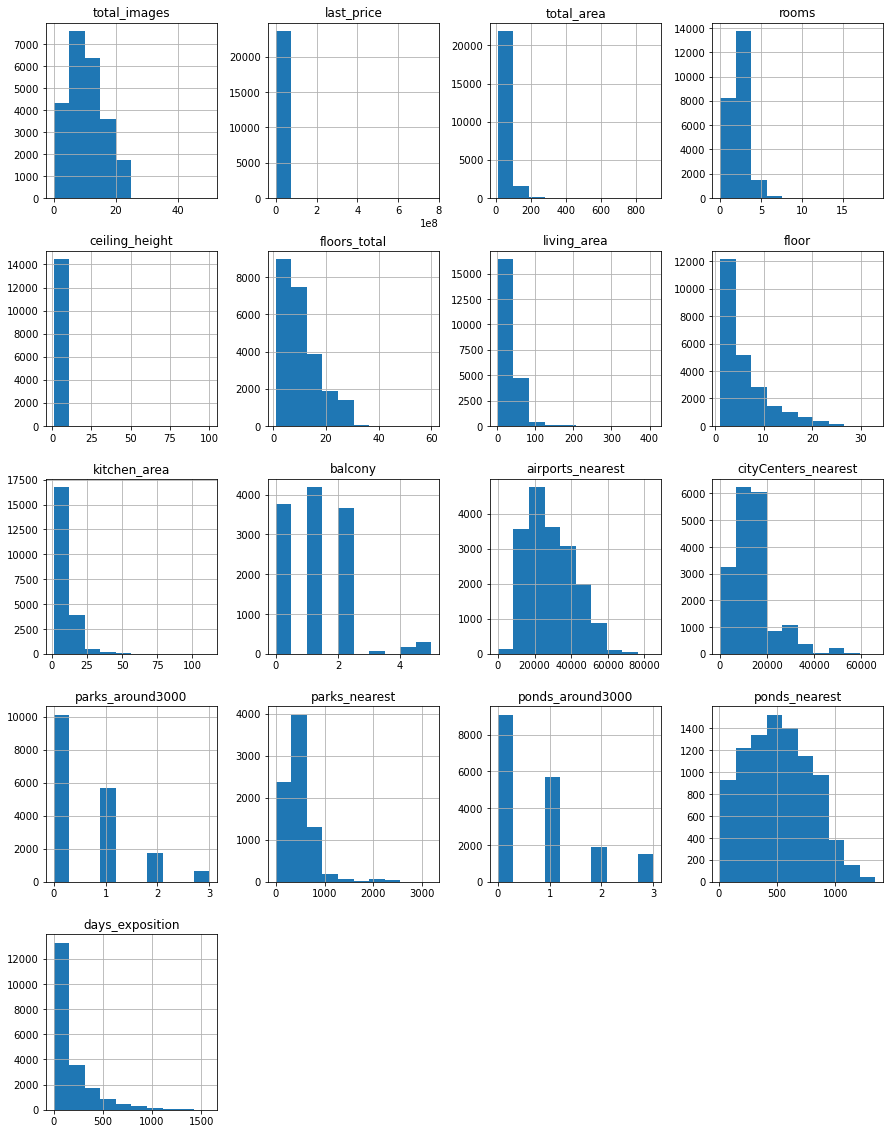

In [3]:
# построение общей гистограммы для всех числовых столбцов. Оси X - единицы измерения, оси Y - число квартир
data.hist(figsize = (15, 20));

In [4]:
# Вывод первых 5 строк для обзора данных
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Обработка пропусков

In [5]:
# определение колонок, содержащих пропуски
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [6]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


#### Графа "Балконы"
Вероятно, что в случае, если балконы не указаны, их нет в данной квартире - заменим пропущенные значения нулем.

In [7]:
# балконы
data['balcony'] = data['balcony'].fillna(0)
data.isna().sum()


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

#### Графа "Населенный пункт"
Строк, содержащих пропуски в этой колонке всего 49. Представляется разумным их удалить, так как в них остутствует ключевая для исследования информация и восстановить ее не представляется возможным.

In [8]:
# удаление строк, гже пропущено значение колонки "Населенный пункт"
data = data.dropna(subset = ['locality_name'])
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9160
floors_total               85
living_area              1898
floor                       0
is_apartment            20890
studio                      0
open_plan                   0
kitchen_area             2269
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000         5510
parks_nearest           15586
ponds_around3000         5510
ponds_nearest           14565
days_exposition          3180
dtype: int64

#### Графа "Жилая площадь"
Заполним пропуски медианным значением жилой площади для каждого количества комнат

In [9]:
# выделим в отдельную колонку год выхода фильма
for rooms in data['rooms'].unique():
    data.loc[(data['rooms'] == rooms) & (data['living_area'].isna()),'living_area'] = data.loc[(data['rooms'] == rooms), 'living_area'].median()
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9160
floors_total               85
living_area                 0
floor                       0
is_apartment            20890
studio                      0
open_plan                   0
kitchen_area             2269
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000         5510
parks_nearest           15586
ponds_around3000         5510
ponds_nearest           14565
days_exposition          3180
dtype: int64

In [10]:
# жилая площадь - заполнение медианным значением для каждого количества комнат
for rooms in data['rooms'].unique():
    data.loc[(data['rooms'] == rooms) & (data['living_area'].isna()),'living_area'] = data.loc[(data['rooms'] == rooms), 'living_area'].median()
data.isna().sum()


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9160
floors_total               85
living_area                 0
floor                       0
is_apartment            20890
studio                      0
open_plan                   0
kitchen_area             2269
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000         5510
parks_nearest           15586
ponds_around3000         5510
ponds_nearest           14565
days_exposition          3180
dtype: int64

#### Графа "Площадь кухни"
Взглянем сначала на диаграмму размаха для колонки "Общая площадь". Мы увидим, что в число выбросов сверху попадают 1204 строки, содержащие данные о квартирах площадью свыше 114.75 метров (верхнее значение правого уса) - 5% датасета.
Но в Санкт-Петербурге сохраняется значительное число коммунальных квартир - с большим числом комнат и большой площадью. Представляется разумным для заполнения пропусков в графе "Площадь кухни" сгруппировать все квартиры в соответствии с их квартилями + в отдельную группу вывести те, что формально являются выбросами сверху. Для каждой из этих групп посчитать медиану площади кухни и добавить эти значения там, где площадь кухни пропущена.


count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

<AxesSubplot:>

44.550000000000004

114.25

-4.550000000000004

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,45.0,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
19,16,14200000.0,121.00,2019-01-09T00:00:00,3,2.75,16.0,76.0,8,NaN,...,12.00,0.0,Санкт-Петербург,38900.0,12843.0,0.0,NaN,0.0,NaN,97.0
35,6,15500000.0,149.00,2017-06-26T00:00:00,5,NaN,5.0,104.0,4,NaN,...,17.00,0.0,Санкт-Петербург,23670.0,3502.0,0.0,NaN,1.0,779.0,644.0
42,13,22000000.0,161.80,2015-07-08T00:00:00,4,2.80,4.0,80.9,2,False,...,17.60,5.0,Петергоф,35416.0,30605.0,2.0,47.0,1.0,907.0,987.0
51,7,45000000.0,161.00,2017-10-17T00:00:00,3,3.20,8.0,38.0,4,NaN,...,50.00,0.0,Санкт-Петербург,32537.0,6589.0,0.0,NaN,3.0,99.0,541.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23574,14,64990000.0,139.00,2015-11-24T00:00:00,3,3.00,8.0,3.0,8,NaN,...,16.00,1.0,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0
23590,0,21187872.0,123.30,2017-04-25T00:00:00,3,NaN,NaN,50.4,18,NaN,...,23.60,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104.0
23600,8,8700000.0,132.00,2018-11-13T00:00:00,3,2.65,9.0,78.0,3,NaN,...,10.00,0.0,Санкт-Петербург,45157.0,17882.0,0.0,NaN,0.0,NaN,60.0
23684,20,21400000.0,145.00,2018-11-02T00:00:00,4,3.00,26.0,71.4,17,NaN,...,15.60,0.0,Санкт-Петербург,11827.0,11459.0,0.0,NaN,0.0,NaN,NaN


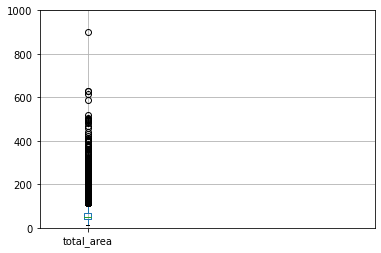

In [11]:
# площадь кухни
display(data['total_area'].describe())
import matplotlib.pyplot as plt
plt.ylim(0, 1000)
plt.xlim(0, 7)
display(data.boxplot(column = 'total_area', figsize = (10, 80)))
q1 = 40.00
q3 = 69.70
# длина усов
whisker = 1.5 * (q3 - q1)
display(whisker)
# граница правого уса
upper_border = q3 + whisker
# граница левого уса
bottom_border = q1 - whisker
display(upper_border, bottom_border)
# число квартир, чья площадь выше 114.75 метров
data.query('total_area > 114.75')

In [ ]:
# площадь кухни - распределение по категориям значений общей площади
def total_area_group(total_area):
    if total_area <= 40.00:
        return 'Q1'
    if total_area > 40.00 and total_area <= 52.00:
        return 'Q2'
    if total_area > 52.00 and total_area <= 69.90:
        return 'Q3'
    if total_area > 69.9 and total_area <= 114.75:
        return 'Q4'
    if total_area > 114.75:
        return 'large'
data['total_area_category'] = data['total_area'].apply(total_area_group)
display(data.pivot_table(index = 'total_area_category', values = 'kitchen_area', aggfunc = 'median'))# функция для подстановки медианных значений в колонку "Площадь кухни"
def kitchen_area_median(total_area_category):
    kitchen_area_unavailable = data.query('kitchen_area.isna()')
    for row in kitchen_area_unavailable.itertuples():
        if row.total_area_category == 'Q1':
            return 8.25
        elif row.total_area_category == 'Q2':
            return 8.00
        elif row.total_area_category == 'Q3':
            return 9.00
        elif row.total_area_category == 'Q4':
            return 12.0
        elif row.total_area_category == 'large':
            return 18.80
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].apply(kitchen_area_median))

,kitchen_area
total_area_category,
Q1,8.25
Q2,8.00
Q3,9.00
Q4,12.00
large,18.80


In [ ]:
# проверка пропусков в графе "Площадь кухни"
data.isna().sum()

#### Графа "Высота потолков"
Для обработки пропусков в графе "Высота потолков" исправим очевидные аномалии (вроде значений 20 метров) и оценим границы нормальных значений. Посчитаем медиану нормальных значений и заполним ею пропуски.

In [ ]:
# исправим очевидно аномальные значения
display(data.groupby('ceiling_height')['first_day_exposition'].count())
def fix_ceiling_height(ceiling_height_fix_list):
    for row in ceiling_height_fix_list:
        for elem in row:
            data['ceiling_height'] = data['ceiling_height'].replace(row[0], row[1])
ceiling_height_fix_list = [
    [20.00, 2.00],
    [22.60, 2.26],
    [24.00, 2.40],
    [25.00, 2.50],
    [26.00, 2.60],
    [27.00, 2.70],
    [27.50, 2.75],
    [32.00, 3.20]
]
fix_ceiling_height(ceiling_height_fix_list)
# проверка правок в колонке "Высота потолков"
display(data.groupby('ceiling_height')['first_day_exposition'].count())

In [ ]:
# рассмотрим диаграмму размаха
display(data['ceiling_height'].describe())
plt.ylim(0, 11)
plt.xlim(0, 7)
data.boxplot(column = 'ceiling_height', figsize = (10, 80))

In [ ]:
# определим границы нормальных значений
q1_ceiling_height = 2.52
q3_ceiling_height = 2.80
# длина усов
whisker_ceiling_height = 1.5 * (q3_ceiling_height - q1_ceiling_height)
# верхняя граница правого уса
upper_border_ceiling_height = q3_ceiling_height + whisker_ceiling_height
# нижняя граница левого уса
bottom_border_ceiling_height = q1_ceiling_height - whisker_ceiling_height
display('Нижняя граница нормальных значений для графы "Высота потолков":', bottom_border_ceiling_height)
display('Верхняя граница нормальных значений для графы "Высота потолков":', upper_border_ceiling_height)

In [ ]:
# определим число строк, где значения высоты потолков выходят за рамки нормы
display('Число строк, где высота потолков выходит за границы нормальных значений:', len(data.query('ceiling_height < 2.10 or ceiling_height > 3.22')), '3.4% датасета')

In [ ]:
# рассчитаем медиану нормальных значений
ceiling_height_normal = data.query('ceiling_height >= 2.10 and ceiling_height <= 3.22')
ceiling_height_normal['ceiling_height'].median()

In [ ]:
# заполним пропуски в графе "Высота потолков" медианой нормальных значений
data['ceiling_height'] = data['ceiling_height'].fillna(2.64)
data.isna().sum()

#### Графа "Количество этажей в доме"
Заполним пропуски медианным значением.

In [ ]:
display(data.groupby('floors_total')['first_day_exposition'].count())
data['floors_total'] = data['floors_total'].fillna(data['floors_total'].median())
data.isna().sum()

#### Не представляется возможным обработать пропуски в графах:
- "Длительность публикации объявления";
- "Расстояние до ближайшего аэропорта" и "Расстояние до центра города";
- "Расстояние до ближайшего парка" и "Расстояние до ближайшего водоема";
- "Число парков в радиусе 3000 метров" и "Число водоемов в радиусе 3000 метров".

NB! Пропуски в графе "Признак апартаментов" исчезнут в момент смены типа данных.

#### Возможные причины появления пропусков
1. Меньше всего пропусков в графе с названием населенного пункта. Вероятно, это случайные пользовательские ошибки, так как для объявлений о продаже недвижимости это слишком важный параметр. Именно поэтому их так мало. К случайным пользовательским ошибкам можно отнести также пропуски в графе с этажностью домов.
2. Обращают на себя внимание пары колонок:
- расстояние до центра + расстояние до аэропорта;
- парки в радиусе 3 км. + водоемы в радиусе 3 км;
- расстояние до ближайшего парка + расстояние до ближайшего водоема.

Число пропусков в этих парах равно или близко к равенству. Кроме того, они описывают схожие по сути параметры недвижимости - картографические данные. Проверка по датам публикации, выполненная до заполнения пропусков медианными значениями, - например, сколько записей о расстоянии до аэропорта и до центра города было в каждую дату - показала, что записи попарно отсутствовали время от времени. Это указывает на технические сбои на этапе публикации. Сюда же может быть отнесена и пара жилая площадь + площадь кухни, хоть в этом случае число пропусков отличается сильнее - почти на 400 записей.

3. Предположить причины пропусков в графах о высоте потолков и длительности публикации сложно. Только на основании типов полей - пользовательское и системное - можно предположить, что в первом случае пропуски - это ошибка пользователя, а во втором - результат сбоя, но других подтверждений нет. Кроме того, высота потолков - важный признак, трудно представить, что порядка трети публикаторов пропустили это поле.

### Изменение типов данных
1. Для колонок о количестве балконов, расстоянии до ближайшего парка / водоема, а также о числе парков и водоемов в радиусе 3 км целые числа более адекватны для операций и восприятия, так как для этих данных невозможны дробные значения.
2. Признак апартамента - аналогично студии и свободной планировке - должен быть булевым значением, так как помещение может либо быть апартаментом, либо нет.
3. Колонка с датой публикации требует типа данных datetime для возможности выполнения с данными арифметических операций.
4. Особый случай - колонка об общей этажности дома. С одной стороны, здесь невозможны дробные значения и удобнее привести данные к целым числам. С другой - в колонке есть пропуски, и нет уверенности, что разумно просто заменить их нулем, это нарушает восприятие (например, этаж 10, но общая этажность - 0). Общая этажность понадобится нам в ходе дальнейшей работы, и количество пропусков невелико относительно объема датасета, поэтому представляется разумным пока оставить эту колонку как есть.

In [ ]:
# преобразование типов данных
data['balcony'] = data['balcony'].astype('int64', errors = 'ignore')
data['floors_total'] = data['floors_total'].astype('int64', errors = 'ignore')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['parks_nearest'] = data['parks_nearest'].astype('int64', errors = 'ignore')
data['ponds_nearest'] = data['ponds_nearest'].astype('int64', errors = 'ignore')
data['parks_around3000'] = data['parks_around3000'].astype('int64', errors = 'ignore')
data['ponds_around3000'] = data['ponds_around3000'].astype('int64', errors = 'ignore')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S', errors = 'ignore')
# проверка результата
data.info()

### Устранение неявных дубликатов

In [ ]:
# обзор неявных дубликатов
display(data['locality_name'].unique())

In [ ]:
# функиця для обработки неявных дубликатов
def update_locality_name(locality_name_list):
    for row in locality_name_list:
        for elem in row:
            data['locality_name'] = data['locality_name'].replace(row[0], row[1])
locality_name_list = [
    ['поселок Гаврилово', 'посёлок Гаврилово'],
    ['поселок городского типа Кузьмоловский', 'посёлок городского типа Кузьмоловский'],
    ['поселок городского типа Лебяжье', 'посёлок городского типа Лебяжье'],
    ['городской посёлок Мга', 'посёлок городского типа Мга'],
    ['городской посёлок Павлово', 'посёлок городского типа Павлово'],
    ['поселок городского типа Рябово', 'посёлок городского типа Рябово'],
    ['поселок Рябово', 'посёлок городского типа Рябово']

,
    ['поселок городского типа Форносово', 'посёлок городского типа Форносово'],
    ['поселок Мельниково', 'посёлок Мельниково'],
    ['поселок Мичуринское', 'посёлок Мичуринское'],
    ['поселок Пансионат Зелёный Бор', 'посёлок Пансионат Зелёный Бор'],
    ['городской поселок Янино-1', 'городской посёлок Янино-1'],
    ['Кудрово', 'деревня Кудрово'],
    ['поселок Бугры', 'посёлок Бугры'],
    ['поселок Аннино', 'посёлок Аннино'],
    ['поселок городского типа Вырица', 'посёлок городского типа Вырица'],
    ['поселок городского типа Токсово', 'посёлок городского типа Токсово'],
    ['поселок Жилгородок', 'посёлок Жилгородок'],
    ['Коробицыно', 'посёлок Коробицыно'],
    ['посёлок Кобралово', 'поселок Кобралово'],
    ['поселок Новый Свет', 'посёлок Новый Свет'],
    ['поселок Перово', 'посёлок Перово'],
    ['поселок Победа', 'посёлок Победа'],
    ['поселок Поляны', 'посёлок Поляны'],
    ['поселок Сумино', 'посёлок Сумино'],
    ['поселок Терволово', 'посёлок Терволово'],
    ['поселок Усть-Луга', 'посёлок Усть-Луга'],
    ['поселок Лисий Нос', 'посёлок Лисий Нос']

]
update_locality_name(locality_name_list)
# проверка результата функции
display(data['locality_name'].unique())

### Редкие и выбивающиеся значения
Создадим таблицу методом describe(), чтобы увидеть потенциальные аномалии. Рассчитаем границы правого и левого усов диаграмм размахов.

In [ ]:
anomaly_overview = data.describe()
anomaly_overview = anomaly_overview.T
anomaly_overview['bottom_whisker'] = anomaly_overview['25%'] - 1.5 * (anomaly_overview['75%'] - anomaly_overview['25%'])
anomaly_overview['upper_whisker'] = anomaly_overview['75%'] + 1.5 * (anomaly_overview['75%'] - anomaly_overview['25%'])
anomaly_overview

По очереди запросим строки, содержащие значения для каждой колонки, выходящие за пределы нормальных значений. Итеративно меняя верхний и/или нижний пределы усов диаграммы размаха и опираясь здравый смысл, определим, какие значения действительно аномальны.

In [ ]:
# аномалии в графе "Цена в момент снятия с публикации", нижняя граница правого уса
display(data.query('last_price >= 12190.0 and last_price < 500000.00').sort_values(by = 'last_price'))
data = data.query('last_price != 12190.0')

Очевидно, что никакая квартира в Санкте-Петербурге не может стоить немногим более 12 тысяч рублей. Удалим эту строку.

In [ ]:
# аномалии в графе "Общая площадь", нижняя граница левого уса
display(data.query('total_area >= 12.0 and total_area < 18.00'))

Общая площадь от 12 до 18 метров может показаться аномалией, так как по закону минимальная жилая площадь на одного человека не может быть менее 18 метров, но большинство этих случаев имеют признак апартаментов. А этот тип жилья имеет свои особенности по сравнению с обычной квартирой. Кроме того, большинство таких объектов расположены в самом Санкт-Петербурге, где много жилья для краткосрочной аренды, к коему часто относятся апартаменты. Представляется разумным сохранить все эти строки.

In [ ]:
# аномалии в графе "Общая площадь", верхняя граница правого уса
total_area_anomaly = data.query('total_area <= 900.0 and total_area > 114.25').sort_values(by = 'total_area', ascending = False)
display(total_area_anomaly['is_apartment'].value_counts())
total_area_anomaly

Памятуя об особенностях жилого фонда в Санкт-Петербурге, очень трудно сказать, если объекты, выходящие за пределы правого уса, действительно являются аномалиями. Их 1244, порядка 5% датасета, а среди них 1092 (почти 88%) имеют признак апартамента. Нельзя исключать, что это объекты для краткосрочной аренды.
Однако единственная в своем роде строка с общей площадью 900 кв.м. выделяется даже в таком случае. Удалим ее.

In [ ]:
data = data.query('total_area != 900')

In [ ]:
# аномалии в графе "Количество комнат", нижняя граница левого уса
data.query('rooms == 0 and studio != True')

In [ ]:
# аномалии в графе "Количество комнат", верхняя граница правого уса
rooms_anomaly = data.query('rooms > 6').sort_values(by = 'rooms')
display(rooms_anomaly['is_apartment'].value_counts())

Похоже, большинство квартир с количеством комнат 0 - студии, и тогда они не могут быть признаны аномалиями.
А объекты, выходящие за границы правого уса, в подавляющем большинстве апартаменты. Как мы говорили применительно к общей площади, эти случаи очень похожи на объекты для краткосрочной аренды.

In [ ]:
# аномалии в графе "Плоащадь кухни", нижняя граница левого уса
data.query('kitchen_area >= 1.3 and kitchen_area < 7.3 and is_apartment == True').sort_values(by = 'kitchen_area', ascending = False)

Мы видим, что левый ус оканчивается нулем, то есть все значения входят в пределы нормы, вплоть до площади кухни 1.3 кв.м.

In [ ]:
# аномалии в графе "Площадь кухни", верхняя граница правого уса
kitchen_area_anomaly = data.query('kitchen_area > 22.8 and kitchen_area <= 112.0').sort_values(by = 'kitchen_area', ascending = False)
kitchen_area_anomaly.describe()

Мы помним про две важные особенности петербургского жилого фонда - обилие коммунальных квартир и объектов для краткосрочной аренды. Поэтому необходимо внимательно рассмотреть строки, выходящие за пределы правого уса. Их 775 единиц.

Если мы рассмотрим с помощью метода `describe()` переменную, в которую вошли все строки, лежащие за пределами правого уса, мы увидим, что предельное "нормальное значение площади кухни среди аномальных" - 53 кв. метра. Запросим строки свыше этого значения в нашем датасете.

In [ ]:
data.query('kitchen_area > 53').sort_values(by = 'total_area', ascending = False).loc[:, ['total_area', 'kitchen_area', 'is_apartment']]

И удалим их.

In [ ]:
data = data.query('kitchen_area < 53')

In [ ]:
# аномалии в графе "Высота потолков", нижняя граница левого уса
data.query('ceiling_height < 2.40').sort_values(by = 'ceiling_height')
# удаление строк, где высота потолков ниже 2.40 метра
data = data.query('ceiling_height >= 2.40')

По закону минимально допустимая высота потолков - 2.4 метра. В датасете 23 строки имеют соответствующее значение ниже этой отсечки. Допустимо и разумно их удалить.

In [ ]:
# аномалии в графе "Высота потолков", верхняя граница правого уса
data.query('ceiling_height > 4.50').sort_values(by = 'ceiling_height', ascending = False)
data = data.query('ceiling_height <= 6.00')

Правый ус диаграммы размаха формально ограничен 2.85 метра. Но мы знаем, что старый фонд Санкт-Петербурга славится впечатляющими высотами потолков. Кроме того, по данным агентств недвижимости, в последние годы появляются элитные объекты с потолками свыше 7 метров. Запросим все записи с высотой потолков свыше 4.5 метра (по личному опыту автора анализа) и увидим, что самое большое условно-адекватное значение высоты потолка - индекс 20264, где высота потолков - 6 метров, расстояние до центра - около километра, стоимость 119 млн рублей, присутствует признак апартаментов. Все, что расположено выше этой строки, уже вызывает сомнения по тем или иным причинам и подлежит удалению.

In [ ]:
# аномалии в графе "Всего этажей в доме", верхняя граница правого уса
display(data.query('floors_total > 33 and floors_total <=60').sort_values(by = 'floors_total', ascending = False))
data = data.query('floors_total <= 36')

Несмотря на то, что верхняя граница правого уса диаграммы размаха проходит по отметке 33 этажа, строки, которые содержат значения от 34 до 36 по совокупности данных выглядят адекватно - похоже, что это современные новостройки в удаленных от центра районах Петербурга. А вот строки с общей этажностью 56 и 60 выглядят совсем неправдоподобно. Удалим их.

In [ ]:
data.duplicated().sum()

In [ ]:
# аномалии в графе "Жилая площадь", нижняя граница левого уса
living_area_anomaly = data.query('living_area >= 2.0 and living_area < 10').sort_values(by = 'living_area', ascending = False)
living_area_anomaly.query('total_area < living_area * 10')

Предположим, что значения жилой площади в пределах первого десятка являются опечатками (например, 2.0 на самом деле 20 квадратных метров и т.п.). Таких случаев всего 25.
Сохраним их в отдельную переменную и проверим гипотезу об опечатках.
В living_area_anomaly всего пять строк, где опечатка может быть причиной аномалии, так как только в этих случаях общая площадь останется больше жилой при умножении значения жилой на 10.
Инвертируем условие и увидим строки, которые не укладываются в гипотезу. - Эти 20 строк, вероятно, являются аномалиями, так как:
- если признать, что это опечатки десятичного знака, то жилая площадь станет больше общей;
- если согласиться, что десятичный знак поставлен правильно, то разница между общей и жилой площадями производит впечатление неадекватной (например, 8 кв.м. жилой при 50 кв.м. общей).

Удалим эти 20 строк из основного датасета.

In [ ]:
data = data.where(~((data['living_area'] >= 2.0) & (data['living_area'] < 10) & (data['total_area'] < data['living_area'] * 10)))
data.query('living_area < 10')

In [ ]:
# исправим те строки, где, по нашему мнению, вкрались опечатки
def fix_living_area(living_area_fix_list):
    for row in living_area_fix_list:
        for elem in row:
            data['living_area'] = data['living_area'].replace(row[0], row[1])
living_area_fix_list = [
    [2.00, 20.0],
    [3.00, 30.0],
    [5.40, 54.0]
]
fix_living_area(living_area_fix_list)
# проверим результат по одной из этих строк
data.loc[3242]

In [ ]:
# аномалии в графе "Жилая площадь", верхняя граница правого уса
data.query('living_area <= 409.7 and living_area > 79.5').sort_values(by = 'living_area', ascending = False)

Среди всех значений жилой площади, выходящих за пределы правого уса, выделяется индекс 19540 - с общей площадью 900 кв.м. и жилой - 409.7. Следующий за ним объект имеет аналогичную жилую площадь, но в полтора раза меньшую площадь общую. Удалим выбивающееся значение.

In [ ]:
# удаление выбивающегося значения в графе "Жилая площадь"
data = data.query('living_area != 409.7')

In [ ]:
# аномалии в графе "Этаж", верхняя граница правого уса
data.query('floor > 17 and floor <= 33').sort_values(by = 'floor', ascending = False)

Анализируя общую этажность мы говорили о том, что несмотря на то, что верхняя граница правого уса диаграммы размаха общей этажности проходит по отметке 33 этажа, строки, которые содержат значения от 34 до 36 по совокупности данных выглядят адекватно - похоже, что это современные новостройки в удаленных от центра районах Петербурга. Мы снова встретились с этими строками, анализируя графу "Этаж". Оставим их в составе датасета.

In [ ]:
# аномалии в графе "Количество балконов", верхняя граница правого уса 
data.query('balcony > 4 and rooms < 4').sort_values(by = 'balcony', ascending = False)

Затруднительно как бы то ни было оценивать количество балконов, но их не может быть больше,чем число комнат + 1 (кухня). Таких строк в датасете 272, но так как в дальнейшем анализе этот параметр не участвует, проигнорируем его.

In [ ]:
# аномалии в графе "Расстояние до ближайшего аэропорта", нижняя граница левого уса 
data.query('locality_name == "Санкт-Петербург" and cityCenters_nearest >= 22801.0 and cityCenters_nearest < 22900.0').sort_values(by = 'airports_nearest', ascending = False)

Одна из строк содержит нулевое значение. Найдем, в каких строках расстояние до центра города примерно совпадает со строкой, где расстояние до азропорта равно нулю Таких строк 4. Выберем наиболее близкое значение и воспользуемся соответствующим расстоянием до аэропорта для исправления аномалии.

In [ ]:
# замена аномального значения в графе "Расстояние до ближайшего аэропорта"
data['airports_nearest'] = data['airports_nearest'].replace(0.0, 21137.0)
# проверка замены
data.query('airports_nearest == 0')

In [ ]:
# аномалии в графе "Расстояние до ближайшего аэропорта", верхняя граница правого уса 
data.query('airports_nearest > 35763.4 and airports_nearest <= 84869').sort_values(by = 'airports_nearest', ascending = False)

Несмотря на то, что формально за границы правого уса выходит свыше 5 тысяч строк, выборочная проверка расстояний по картам показывает, что они адекватны.

In [ ]:
# аномалии в графе "Расстояние до центра города", верхняя граница правого уса 
data.query('cityCenters_nearest > 34754.5 and cityCenters_nearest <= 65968').sort_values(by = 'cityCenters_nearest', ascending = False)

In [ ]:
cityCenters_pivot = data.pivot_table(index = 'locality_name', values = 'cityCenters_nearest', aggfunc = 'median')
cityCenters_pivot

Проверка медианных значений показывает, что расстояние до центра города в случае с населенными пунктами, расположенными за пределами Санкт-Петербурга, указано именно до центра СПб.

In [ ]:
# аномалии в графе "Длительность публикации", верхняя граница правого уса 
data.query('days_exposition > 510 and days_exposition <= 1580').sort_values(by = 'days_exposition', ascending = False)

За пределы нормальных значений сверху выходят 1673 строки, однако трудно сказать, являются ли они аномалиями, не имея достаточно глубоких представлений об устройстве рынка недвижимости. Оставим их как есть.

In [ ]:
duplicated_data = data[data.duplicated()]
duplicated_data

В датасете выявлены 19 полностью пустых строк. Удалим их.

In [ ]:
# удаление явных дубликатов
data = data.drop_duplicates()
# проверка результата удаления
data.duplicated().sum()

#### Особенности данных
1. Значения, выходящие за пределы правого (а иногда и левого) уса, при внимательном рассмотрении не могут быть ппризнаны аномалиями в целом ряде случаев (например, высота потолков, жилая площадь).
2. Истинными аномалиями, как правило, являются пользовательские ошибки (например, высота потолков, жилая площадь).
3. Выборочная проверка показала, что в случае с населенными пунктами вне пределов Санкт-Петербурга расстояние до центра города указано именно до СПб.

### Добавление новых столбцов

In [ ]:
# цена одного квадратного метра
data['square_meter_price'] = data['last_price'] / data['total_area']
# день недели, когда было опубликовано
data['publication_weekday'] = pd.DatetimeIndex(data['first_day_exposition']).weekday
# месяц публикации
data['publication_month'] = pd.DatetimeIndex(data['first_day_exposition']).month
# год публикации
data['publication_year'] = pd.DatetimeIndex(data['first_day_exposition']).year
# функция для определения типа этажа квартиры
def func(arg):
    if arg.floor == 1:
        return 'первый'
    if arg.floor == arg.floors_total:
        return 'последний'
    return 'другой'
data['floor_type'] = data.apply(func, axis=1)
# расстояние до центра города в км
data['cityCenters_km'] = data['cityCenters_nearest'] / 1000
# округление расстояния до центра города
import math
data['cityCenters_km'] = data['cityCenters_km'].round(decimals = 0)
data['cityCenters_km'] = data['cityCenters_km'].astype('int64', errors = 'ignore')

In [45]:
data.head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_category
0,20.0,13000000.0,108.00,2019-03-07,3.0,2.70,16.0,51.00,8.0,True,...,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,Q4
1,7.0,3350000.0,40.40,2018-12-04,1.0,2.64,11.0,18.60,1.0,True,...,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,Q2
2,10.0,5196000.0,56.00,2015-08-20,2.0,2.64,5.0,34.30,4.0,True,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,Q3
3,0.0,64900000.0,159.00,2015-07-24,3.0,2.64,14.0,45.00,9.0,True,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,large
4,2.0,10000000.0,100.00,2018-06-19,2.0,3.03,14.0,32.00,13.0,True,...,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,Q4
5,10.0,2890000.0,30.40,2018-09-10,1.0,2.64,12.0,14.40,5.0,True,...,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,Q1
6,6.0,3700000.0,37.30,2017-11-02,1.0,2.64,26.0,10.60,6.0,True,...,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,Q1
7,5.0,7915000.0,71.60,2019-04-18,2.0,2.64,24.0,30.50,22.0,True,...,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,Q4
8,20.0,2900000.0,33.16,2018-05-23,1.0,2.64,27.0,15.43,26.0,True,...,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,Q1
9,18.0,5400000.0,61.00,2017-02-26,3.0,2.50,9.0,43.60,7.0,True,...,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,Q3


### Исследовательский анализ данных

In [ ]:
# гистограмма общей площади
data['total_area'].hist(bins = 100, range = (0, 300))

In [ ]:
# гистограмма жилой площади
data['living_area'].hist(bins = 100, range = (0, 200))

In [ ]:
# гистограмма площади кухни
data['kitchen_area'].hist(bins = 100, range = (0, 60))

In [ ]:
data['last_price'].describe()

In [ ]:
# гистограмма цены объекта
data['last_price'].hist(bins = 100)

In [ ]:
# гистограмма количества комнат
data['rooms'].hist(bins = 15, range = (0, 10))

In [ ]:
# гистограмма высоты потолков
data['ceiling_height'].hist(bins = 10, range = (0, 10))

In [ ]:
# гистограмма этажа квартиры
data['floor'].hist(bins = 100, range = (0, 30))

In [ ]:
# гистограмма типа этажа квартиры
data['floor_type'].hist(bins = 3)

In [ ]:
# гистограмма общего количества этажей в доме
data['floors_total'].hist(bins = 100, range = (0, 30))

In [ ]:
# гистограмма расстояния до центра города в метрах
data['cityCenters_nearest'].hist(bins = 100, range = (0, 80000))

In [ ]:
# гистограмма расстояния до ближайшего аэропорта
data['airports_nearest'].hist(bins = 100, range = (0, 80000))

In [ ]:
# гистограмма расстояния до ближайшего парка
data['parks_nearest'].hist(bins = 10)

In [ ]:
data['publication_weekday'].hist(bins = 7)

In [ ]:
data['publication_month'].hist(bins = 12)

#### Наблюдения по параметрам
1. Пики на гистограммах total_area, living_area, rooms отражают самые распространенные и популярные объекты - 1-, 2-х и 3-х комнатные квартиры.
2. Два пика на гистограмме kitchen_area - около 7 кв.м. и чуть не доходя до 20 кв.м. - указывают на обилие объектов для краткосрочной аренды и коммунальных квартир.
3. Подавляющее большинство объектов стоит в пределах 10 млн. руб.
4. Наиболее частая высота потолков - в пределах 3 метров. Это косвенно подтверждает обилие квартир 1-, 2-х и 3-х комнатных в домах типовой застройки, которое мы описали в п.1.
5. Пик квартир на данном этаже приходится на второй этаж с постепенным снижением числа квартир по мере роста этажа.
6. Наиболее распространненый тип этажа - другой, то есть не первый и не последний.
7. Пики общей этажности дома совпадают с этажностью типовых домов, а именно 5, 9, 12, 16 и 25 этажей. Это снова подтверждает наши пункты 1 и 4.
8. Расстояние до центра города имеет 2 пика от 13 до 15 км. Это относительно новые кварталы вне исторического центра. И это снова подтвержает пункты 1, 4, 7 о распространнности объектов типовой застройки.
9. Диаграмма расстояния до аэропорта говорит о том, что значительная часть объектов расположена в пределах 10 км от аэропорта.
10. Большинство объектов расположены не более чем в 500 метрах от парка.
11. По рабочим дням недели объявлений публикуется примерно в 2 раза больше, чем в субботу и воскресенье.
12. С точки зрения месяца, самые активные в году - февраль, март, апрель, а также ноябрь. Самый "тихий" - май.

#### Скорость продажи квартир

In [ ]:
# гистограмма колонки "Длительность публикации"
data['days_exposition'].hist(bins = 100)

In [ ]:
# расчет среднего и медианы
display(data['days_exposition'].describe())
display('Верхняя граница правого уса:', 510)

In [ ]:
display(data.query('days_exposition > 510').count())
data.query('days_exposition > 510').hist('days_exposition', bins = 100)

In [ ]:
# гистограмма длительности публикации менее 200 дней
data.query('days_exposition < 50').hist('days_exposition', bins = 100)

Мы рассмотрели квартили колонки days_exposition и расчитали верхнюю границу правого уса. Она находится на отметке 510 дней. Стало быть, все продажи, которые потребовали большего времени, можно назвать чрезмерно долгими. Всего их 1668 единиц.

Мы можем назвать очень быстрыми продажи, которые заняли менее 45 дней, так как именно на отметку 45 дней приходится самый высокий пик числа продаж, стало быть с него начинаются наиболее типичные значения. Медианное значение длительности публикации при это 95 дней. Эту цифру - порядка трех месяцев - мы можем считать обычным сроком продажи квартиры.

#### Факторы, влияющие на общую (полную) стоимость объекта

In [ ]:
# матрица корреляции
data.corr()

In [ ]:
# диаграмма рассеяния зависимости цены от общей площади
data.sort_values('last_price').plot(x='total_area', y='last_price', kind = 'scatter', grid=True, figsize=(10, 3))

In [ ]:
data.query('last_price > 100000000').sort_values(by = 'last_price', ascending = False)

Диаграмма показывает нам, что при стоимости квартиры до 100 млн. руб. зависимость цены от общей площади прямая, и на отрезке от 100 до 200 млн. тенденция сохраняется в целом, хотя и с особенностями. Однако при цене свыше 200 млн. мы видим 4 однозначных выброса. Удалим их.

In [ ]:
data = data.query('last_price < 289238400.0')

In [ ]:
# диаграмма рассеяния зависимости цены от жилой площади
data.sort_values('last_price').plot(x='living_area', y='last_price', kind = 'scatter', grid=True, figsize=(10, 3))

In [ ]:
# диаграмма рассеяния зависимости цены от площади кухни
data.sort_values('last_price').plot(x='kitchen_area', y='last_price', kind = 'scatter', grid=True, figsize=(10, 3))

Три параметра - общую площадь, жилую площадь и площадь кухни - объединяет похожая диаграмма рассеяния. При стоимости п пределах 50 млн. руб. цена растет при росте второго показателя. При более высокой стоимости ценденция сохраняется, хотя и с частными случаями.

In [ ]:
# график зависимости цены от количества комнат
price_rooms_dep = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = 'median')
price_rooms_dep

In [ ]:
price_rooms_dep.plot(style='o-', xlim=(-0.5, 20), grid=True, figsize=(10, 3))

Цена стабильно растет при росте числа комнат, однако на отметке 7 комнат рост прекращается. Цена еще растет, начиная с отметки 10 комнат, но по сравнению с диапазоном от 0 до 7 рост очень плавный.

In [ ]:
# график зависимости цены от типа этажа
price_floor_type_dep = data.pivot_table(index = 'floor_type', values = 'last_price', aggfunc = 'median')
price_floor_type_dep

Ожидаемо любой другой этаж кроме первого и последнего повышает стоиомость квартиры, при этом первый снижает стоимость сильнее последнего.

In [ ]:
# график зависимости цены от дня недели публикации
price_weekday_dep = data.pivot_table(index = 'publication_weekday', values = 'last_price', aggfunc = 'median')
price_weekday_dep

In [ ]:
price_weekday_dep.plot(style='o-', xlim=(-0.5, 7), grid=True, figsize=(10, 3))

Самые дорогие квартиры публикуются во вторник и среду, а самые дешевые в период уикенда.

In [ ]:
# график зависимости цены от месяца публикации
price_month_dep = data.pivot_table(index = 'publication_month', values = 'last_price', aggfunc = 'median')
price_month_dep

In [ ]:
price_month_dep.plot(style='o-', xlim=(-0.5, 14), grid=True, figsize=(10, 3))

В апреле стоимость квартир самая высокая, а в июне - самая низкая. Это выглядит как подтверждения сезонности рынка недвижимости: много желающих купить перед летом - высокая цена; все разъезжаются и активность низкая - снижается и стоимость у тех квартир, чью продавцы торопятся продать свое имущество.

In [ ]:
# график зависимости цены от года публикации
price_year_dep = data.pivot_table(index = 'publication_year', values = 'last_price', aggfunc = 'median')
price_year_dep

In [ ]:
price_year_dep.plot(style='o-', grid=True, figsize=(10, 3))

График показывает, что в период с 2014 по 2016 годы цены на недвижимость падали, далее до 2018 оставались стабильными и с началом 2018 снова начали расти.

In [ ]:
# график зависимости общей площади от года публикации
total_area_year_dep = data.pivot_table(index = 'publication_year', values = 'total_area', aggfunc = 'median')
total_area_year_dep

In [ ]:
total_area_year_dep.plot(style='o-', grid=True, figsize=(10, 3))

Попытка рассмотреть дополнительно динамику общей площади в течение 2014 - 2019 годов показывает, что одновренменно со снижением стоимости происходило и снижение площади продаваемых объектов, а также новый рост площади совпал с ростом цены после наступления 2018 года. При этом кривая цены поднимается быстрее кривой площади.

Ключевым фактором стоимости объекта на наш взгляд является общая площадь.

#### Средняя цена квадратного метра в 10 населенных пунктах с наибольшим колчеством объявлений

In [ ]:
locality_name_leaders = data.pivot_table(index = 'locality_name', values = 'first_day_exposition', aggfunc = 'count').sort_values(by = 'first_day_exposition', ascending = False).head(10)
locality_name_leaders
locality_name_square_meter_price = data.pivot_table(index = 'locality_name', values = 'square_meter_price', aggfunc = 'mean')
locality_name_square_meter_price
locality_name_leaders['square_meter_mean_price'] = locality_name_square_meter_price['square_meter_price']
locality_name_leaders

В десятку самых дорогих с точки зрения стоимости квадратного метра населенных пунктов входит Санкт-Петербург, а также наиболее близко расположенные к нему пригороды - исторические и современные.

#### Средняя цена каждого километра в расстоянии до центра города в Санкт-Петербурге

In [ ]:
# корреляция стоимости и расстояния до центра города
data['last_price'].corr(data['cityCenters_km'])

In [ ]:
spb_objects = data.query('locality_name == "Санкт-Петербург"')
spb_objects = spb_objects.loc[:, ['last_price', 'cityCenters_km']]
spb_objects.sort_values(by = 'last_price')

In [ ]:
spb_objects_pivot = spb_objects.pivot_table(index = 'cityCenters_km', values = 'last_price', aggfunc = 'median')
spb_objects_pivot

In [ ]:
spb_objects_pivot.plot(style='o-', grid=True, figsize=(10, 3), title = 'Заголовок');

Хотя присутствуют и колебания и одно из них - весьма существенное, очевидна общая тенденция к снижениию стоимости объекта по мере удаления от центра города. 

In [ ]:
def difference_km_price():
    result = []
    prev_price = 0
    for row in spb_objects_pivot.itertuples():
        if prev_price != 0:
            result.append(prev_price - row.last_price)
        else:
            result.append(0)
        prev_price = row.last_price
    return result
        
difference_km_price()

In [ ]:
spb_objects_pivot['difference'] = difference_km_price()
spb_objects_pivot

In [ ]:
spb_objects_pivot['difference'].mean()

Средняя стоимость каждого километра составляет порядка 300 тысяч.

Расчет общей корреляции цены и удаленности от центра города, расчет разницы медианной стоимости объекта на каждом километре и расчет средней разницы указывают на то, что несмотря на колебания, существует общая тенденция к снижению цены объекта по мере удаления от центра. Средняя разница и составляет порядка 300 тыс. руб., но в некоторых случаях абсолютная разница есть отрицательное число, то есть объект находится дальше от центра, а стоит дороже. Вероятно, существуют факторы,которые нивелируют удаленность от центра.

### Общий вывод

* Датасет содержит значительное количество пропусков. Часть из них могла повлиять на результаты, часть — нет.
* На работу с редкими и выбивающимися значениями накладывают отпечаток особенности жилого фонда Санкт-Петербурга — обилие коммунальных квартир, объектов для краткосрочной аренды, а также нетиповая застройка исторического центра. Поэтому значения, выходящие за пределы правого и левого усов не всегда можно однозначно отнести к аномалиям.
* При этом есть признаки того, что наиболее распространенными объектами для продажи являются объекты типовой застройки — 1-2-3х-комнатные квартиры в домах 5-9-12-16-25ти этажей.
* Обычный срок продажи квартиры в Санкт-Петербурге и окрестностях — порядка 3 месяцев, однако есть объекты, находящиеся на рынке по нескольку лет. Трудно сказать, если это случайно забытые объявления или действительно сложные для продажи объекты.
* Наибольшим влиянием на стоимость обладает общая площадь.
* В 2018 году стоимость недвижимости снова стала расти после падения 2014 — 2016 годов и стабильной цены в 2016 — 2018 годах. Динамика общей площади продаваемых квартир за аналогичный период почти полностью совпадает: снижение в 2014 - 2016, стабильность до 2018 и последующий рост.
* В десятку самых дорогих с точки зрения стоимости квадратного метра населенных пунктов входит Санкт-Петербург, а также наиболее близко расположенные к нему пригороды - исторические и современные. 
* Удаленность от центра не имеет однозначного прямого влияния на стоимость объекта, другие факторы тоже играют роль.